In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("default")

# 데이터 로딩
df = pd.read_csv("../../data_csv/Antibody_Developability.csv")

# 확인
df.shape, df.columns.tolist()

((246, 9),
 ['antibody_id',
  'antibody_name',
  'vh_protein_sequence',
  'vl_protein_sequence',
  'light_aligned_aho',
  'heavy_aligned_aho',
  'hc_subtype',
  'lc_subtype',
  'hierarchical_cluster_IgG_isotype_stratified_fold'])

“시간축 대용” 변수 정의
	•	이건 예측을 위한 feature engineering이 아님
	•	“국소적 변화가 존재하는 연속값”을 만들기 위한 최소 조치

In [4]:
# 분석 편의를 위해 index를 pseudo-order로 사용
df = df.reset_index(drop=True)

# VH / VL 길이 계산 (이미 앞에서 했어도, 이 노트북은 독립적으로 유지)
df["vh_length"] = df["vh_protein_sequence"].str.len()
df["vl_length"] = df["vl_protein_sequence"].str.len()

df[["vh_length", "vl_length"]].describe()

,vh_length,vl_length
count,246.000000,246.000000
mean,119.504065,108.577236
std,3.210630,2.275004
min,111.000000,104.000000
25%,117.000000,107.000000
50%,119.000000,107.000000
75%,121.000000,111.000000
max,130.000000,113.000000


국소 변화 시각화 (Raw signal)
	•	완전 백색잡음 ❌
	•	하지만 명확한 규칙도 ❌

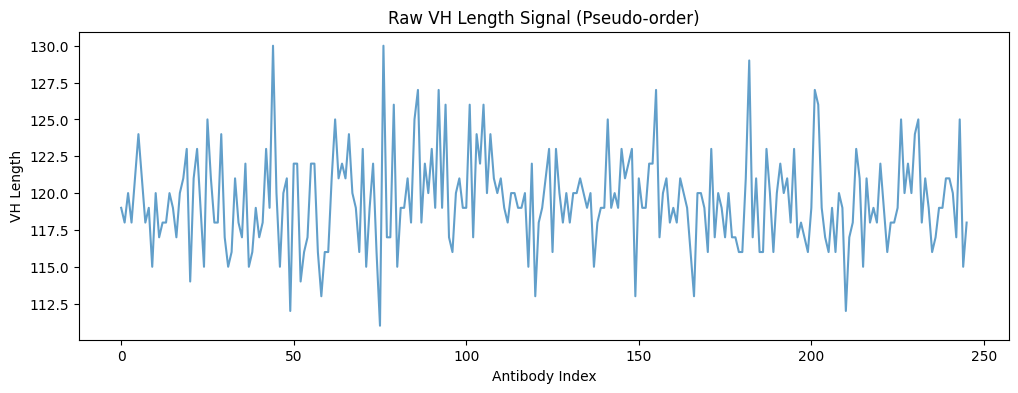

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(df["vh_length"], alpha=0.7)
plt.title("Raw VH Length Signal (Pseudo-order)")
plt.xlabel("Antibody Index")
plt.ylabel("VH Length")
plt.show()

 Rolling 평균으로 “단기 추세”만 보기
 	•	모델 ❌
	•	성능 ❌
	•	smoothing 하나로도
→ *“방향성은 완전히 붕괴되지 않는다”*는 감각만 확보

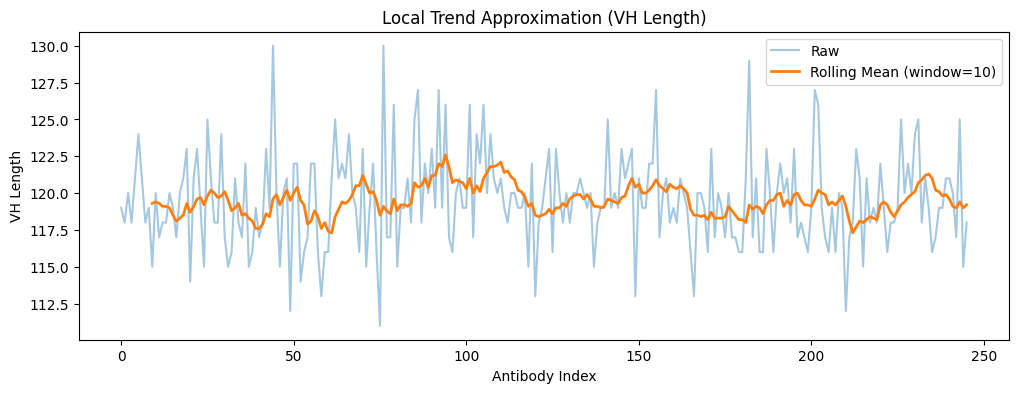

In [6]:
window = 10  # 짧은 horizon

df["vh_length_roll_mean"] = df["vh_length"].rolling(window=window).mean()

plt.figure(figsize=(12, 4))
plt.plot(df["vh_length"], alpha=0.4, label="Raw")
plt.plot(df["vh_length_roll_mean"], linewidth=2, label=f"Rolling Mean (window={window})")
plt.title("Local Trend Approximation (VH Length)")
plt.xlabel("Antibody Index")
plt.ylabel("VH Length")
plt.legend()
plt.show()

VL 쪽에서도 동일한 현상 확인
	•	“이 데이터는 아무 신호도 없다”라는 반박 차단
	•	동시에 “이걸로 안정적 판단이 가능하다”는 주장도 안 함

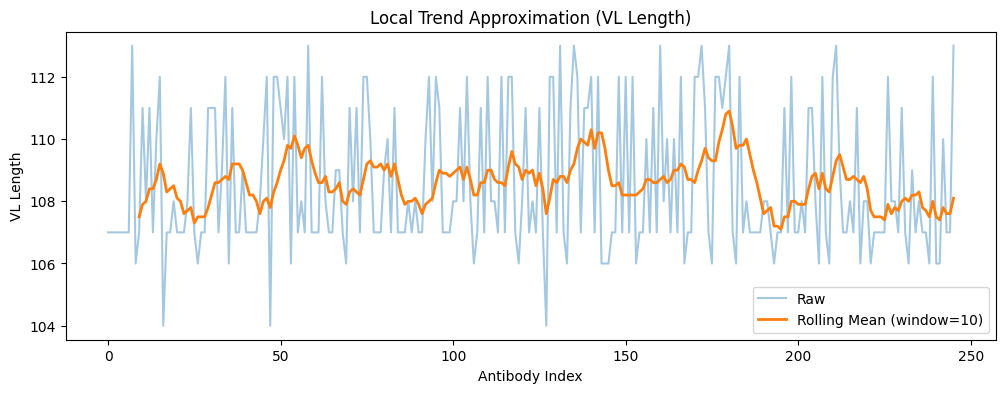

In [7]:
df["vl_length_roll_mean"] = df["vl_length"].rolling(window=window).mean()

plt.figure(figsize=(12, 4))
plt.plot(df["vl_length"], alpha=0.4, label="Raw")
plt.plot(df["vl_length_roll_mean"], linewidth=2, label=f"Rolling Mean (window={window})")
plt.title("Local Trend Approximation (VL Length)")
plt.xlabel("Antibody Index")
plt.ylabel("VL Length")
plt.legend()
plt.show()

1-step lag 비교

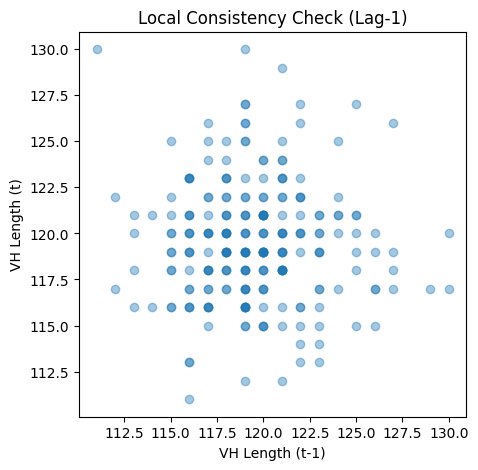

In [8]:
# 1-step lag
df["vh_length_lag1"] = df["vh_length"].shift(1)

plt.figure(figsize=(5, 5))
plt.scatter(
    df["vh_length_lag1"],
    df["vh_length"],
    alpha=0.4
)
plt.xlabel("VH Length (t-1)")
plt.ylabel("VH Length (t)")
plt.title("Local Consistency Check (Lag-1)")
plt.show()

### Core 1 – Local Predictability Check (Conclusion)

- Developability 관련 연속 변수는 완전히 무작위적이지 않다.
- 단기적 변화 방향은 단순한 smoothing 수준에서도 부분적으로 재현된다.
- 그러나 이 정도의 국소 예측 가능성은 설계 판단을 안정화하기에 충분하지 않다.

→ 이후 Core 2–3에서는  
이 ‘불완전한 예측 신호’를 기준으로  
설계 판단이 어떻게 흔들리는지를 분석한다.